In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
import keras_nlp

print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("TensorFlow version: ", tf.__version__)

Numpy version:  1.26.4
Pandas version:  2.2.3
TensorFlow version:  2.18.0


In [15]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
X = train_df["text"]
y = train_df["target"]

X_test = test_df["text"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
BATCH_SIZE = 32
EPOCHS = 5
NUM_TRAINING_EXAMPLES = train_df.shape[0]

classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer = keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 1337s 7s/step - accuracy: 0.6948 - loss: 0.5864 - val_accuracy: 0.8378 - val_loss: 0.3965
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 1504s 8s/step - accuracy: 0.8386 - loss: 0.3869 - val_accuracy: 0.8464 - val_loss: 0.3801


48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step


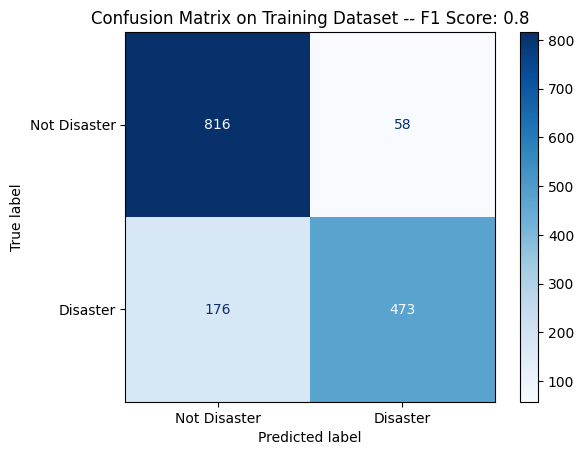

In [21]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

y_val_pred = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_val_pred, "Training")

In [ ]:
classifier.save('distilBERT_classifier.h5')
loss, accuracy = classifier.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8395 - loss: 0.3865
Validation Accuracy: 0.8464


In [ ]:
y_pred = classifier.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    "id": test_df["id"],  # Ensure the test set has an "id" column
    "target": np.argmax(y_pred, axis=1)
})

# Save to CSV
current_time = datetime.now().strftime('%Y%m%d_%H%M')
submission.to_csv("Prediction/submission_" + current_time + ".csv", index=False)